#  Jupyter Notebook for *A Deep Learning Algorithm for High-Dimensional Exploratory Item Factor Analysis*

## Code Author: Christopher J. Urban

This notebook is for conducting amortized importance-weighted variational inference for exploratory item factor analysis.

First, we'll import packages and set some runtime parameters.

In [36]:
from __future__ import print_function
# !pip install torch
# !pip install torchvision
import torch
from torchvision import datasets, transforms
import sys
import timeit
#!pip install factor_analyzer
from factor_analyzer import Rotator # May need to be installed; see https://pypi.org/project/factor-analyzer/
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from pylab import *

from utils import *
from helper_layers import *
from base_class import *
from mirt_vae import *
from read_data import *

# Re-import some packages to reload functions without needing to restart the kernel. jupyter notebook doesn't update the files in the same kernel
import sys, importlib
importlib.reload(sys.modules["utils"])
importlib.reload(sys.modules["helper_layers"])
importlib.reload(sys.modules["base_class"])
importlib.reload(sys.modules["mirt_vae"])
importlib.reload(sys.modules["read_data"])

from utils import *
from helper_layers import *
from base_class import *
from mirt_vae import *
from read_data import *

# Suppress scientific notation.
np.set_printoptions(suppress = True)

# Print full arrays.
np.set_printoptions(threshold = sys.maxsize)

# If CUDA is available, use it.
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
kwargs = {"num_workers" : 1, "pin_memory" : True} if cuda else {}

# Set log interval.
ipip_log_interval = 200

## IPIP-FFM Analyses

Make IPIP-FFM data loaders.

In [37]:
ipip_filename = "ipip_ffm_recoded.csv"
# Python iterable over a dataset, loads data from dataset input, 
# yields batched samples instead of individual samples, 
# shuffled sampler automatically constructed
# Full data set.
ipip_loader = torch.utils.data.DataLoader(
    csv_dataset(csv_file = ipip_filename,
                which_split = "full",
                transform = to_tensor()),
    batch_size = 32, shuffle = True, **kwargs)

# Test data set.
ipip_test_loader = torch.utils.data.DataLoader(
    csv_dataset(csv_file = ipip_filename,
                which_split = "test-only",
                test_size = 0.025,
                transform = to_tensor()),
    batch_size = 32, shuffle = True, **kwargs)

# Train data set.
ipip_train_loader = torch.utils.data.DataLoader(
    csv_dataset(csv_file = ipip_filename,
                which_split = "train-only",
                test_size = 0.025,
                transform = to_tensor()),
    batch_size = 32, shuffle = True, **kwargs)

In [17]:
latent_dims

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Fit model and extract some fitted values.

In [16]:
# Set random seeds.
seed = 1
# sets the seed for generating random numbers
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize model.
print("\nStarting fitting")

# starting the timer to count how much time is taken to run code
start = timeit.default_timer()
ipip_vae = MIRTVAEClass(input_dim = 250, # number of columns in binarized data matrix
                        inference_model_dims = [130], # list of neural network hidden layer sizes
                        latent_dim = 5, # refers to the output num of dimensions after encoding
                        n_cats = [5] * 50, # list of number of categories for each item (because it's a range 1-5)
                        learning_rate = 5e-3, # rate at which the model learns 
                        device = device,
                        log_interval = ipip_log_interval,
                        steps_anneal = 1e3)

"""
Fit model.
Note: iw_samples can be increased to improve the approximation to the MMLE.
As described in the paper, iw_samples = 5 seems to perform well in practice.
"""
ipip_vae.run_training(ipip_loader, ipip_test_loader, iw_samples = 5) # run training on the full dataloader and test loader

# stopping timer
stop = timeit.default_timer()
run_time = stop - start
print("Fitting completed in", round(run_time, 2), "seconds")

# Extract estimated loadings and intercepts.
loadings = ipip_vae.model.loadings.weight.data.numpy()
intercepts = ipip_vae.model.intercepts.bias.data.numpy()

"""
Rotate loadings and extract factor correlations.
Note: In the paper I used geomin rotation, whereas here I use oblimin.
"""
rotator = Rotator(method = "oblimin")
rot_loadings = rotator.fit_transform(loadings)
cor_mat = rotator.phi_

"""
Compute approximate log-likelihood.
Note: This computation can be sped up or slowed down by decreasing or increasing
iw_samples, respectively. In the paper, I set iw_samples = 5000. 
"""
print("\nComputing approx. LL")
start = timeit.default_timer()
ll = ipip_vae.bic(ipip_test_loader,
                  iw_samples = 100)[1]
stop = timeit.default_timer()
print("Approx. LL computed in", round(stop - start, 2), "seconds")




Starting fitting
Fitting completed in 142.02 seconds

Computing approx. LL
Approx. LL computed in 5.92 seconds


Print and save factor loadings heatmap.

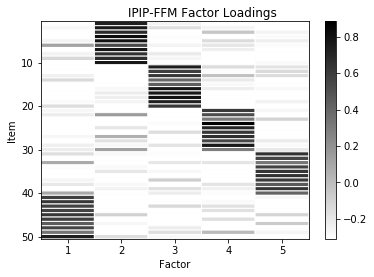

In [12]:
norm_loadings = normalize_loadings(rot_loadings)
c = pcolor(invert_factors(norm_loadings))
set_cmap("gray_r")
colorbar() 
c = pcolor(invert_factors(norm_loadings), edgecolors = "w", linewidths = 1, vmin = 0) 
xlabel("Factor")
ylabel("Item")
xticks(np.arange(loadings.shape[1]) + 0.5,
       ["1", "2", "3", "4", "5"])
yticks(np.array([10, 20, 30, 40, 50]) - 0.5, ["10", "20", "30", "40", "50"])
plt.gca().invert_yaxis()
suptitle("IPIP-FFM Factor Loadings", y = 0.93)
savefig("loadings_heatmap.pdf")

In [38]:
# Extract log likelihood
log_likelihoods = generate_log_likelihood(seed =1,
                            dimensions = 5,
                            input_dim = 250,
                            inference_model_dims = [130],
                            n_cats = [5] * 50,
                            learning_rate = 5e-3,
                            device = device,
                            log_interval = ipip_log_interval,
                            steps_anneal = 1e3,
                            ipip_train_loader = ipip_train_loader, 
                            ipip_test_loader = ipip_test_loader,
                            iw_samples_training = 5,
                            iw_samples_bic = 100)



Starting fitting for P = 1
Model fitted, run time = 130.11 seconds
Approx. LL stored, computed in 5.66 seconds

Starting fitting for P = 2
Model fitted, run time = 233.36 seconds
Approx. LL stored, computed in 6.13 seconds

Starting fitting for P = 3
Model fitted, run time = 116.93 seconds
Approx. LL stored, computed in 6.64 seconds

Starting fitting for P = 4
Model fitted, run time = 125.91 seconds
Approx. LL stored, computed in 6.54 seconds

Starting fitting for P = 5
Model fitted, run time = 133.56 seconds
Approx. LL stored, computed in 5.88 seconds


Latent dimension = 1 Approx. LL = -876788.71
Latent dimension = 2 Approx. LL = -847607.55
Latent dimension = 3 Approx. LL = -825164.77
Latent dimension = 4 Approx. LL = -808162.61
Latent dimension = 5 Approx. LL = -792264.79


Compute predicted approximate negative log-likelihood for latent dimensions P = 1, ..., 10.

In [6]:
ll_ls = []
latent_dims = np.arange(1, 11).tolist()
for latent_dim in latent_dims:
    print("\nStarting fitting for P =", latent_dim)
    
    # Set random seeds.
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize model.
    start = timeit.default_timer()
    ipip_vae = MIRTVAEClass(input_dim = 250,
                            inference_model_dims = [int((250 + 2 * latent_dim) / 2)], # adjust NN size for different P
                            latent_dim = latent_dim,
                            n_cats = [5] * 50,
                            learning_rate = 5e-3,
                            device = device,
                            log_interval = ipip_log_interval,
                            steps_anneal = 1e3)

    # Fit model.
    ipip_vae.run_training(ipip_train_loader, ipip_test_loader, iw_samples = 5)
    stop = timeit.default_timer()
    
    print("Model fitted, run time =", round(stop - start, 2), "seconds")
    
    # Save predicted approximate negative log-likelihood.
    torch.manual_seed(seed)
    np.random.seed(seed)
    start = timeit.default_timer()
    ll_ls.append(-ipip_vae.bic(ipip_test_loader, iw_samples = 100)[1]) # I set iw_samples = 5000 in the paper
    stop = timeit.default_timer()
    
    print("Approx. LL stored, computed in", round(stop - start, 2), "seconds")
    
print("\n")
for idx, dim in enumerate(latent_dims):
    print("Latent dimension =", dim, "Approx. LL =", round(-ll_ls[idx], 2))


Starting fitting for P = 1
Model fitted, run time = 115.24 seconds
Approx. LL stored, computed in 5.72 seconds

Starting fitting for P = 2
Model fitted, run time = 175.49 seconds
Approx. LL stored, computed in 5.75 seconds

Starting fitting for P = 3
Model fitted, run time = 210.74 seconds
Approx. LL stored, computed in 5.58 seconds

Starting fitting for P = 4
Model fitted, run time = 292.23 seconds
Approx. LL stored, computed in 6.6 seconds

Starting fitting for P = 5
Model fitted, run time = 177.65 seconds
Approx. LL stored, computed in 7.61 seconds

Starting fitting for P = 6
Model fitted, run time = 151.64 seconds
Approx. LL stored, computed in 6.1 seconds

Starting fitting for P = 7
Model fitted, run time = 149.04 seconds
Approx. LL stored, computed in 6.48 seconds

Starting fitting for P = 8
Model fitted, run time = 256.7 seconds
Approx. LL stored, computed in 6.99 seconds

Starting fitting for P = 9
Model fitted, run time = 253.69 seconds
Approx. LL stored, computed in 7.2 seco

Print and save scree plot.

/Users/sharahe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


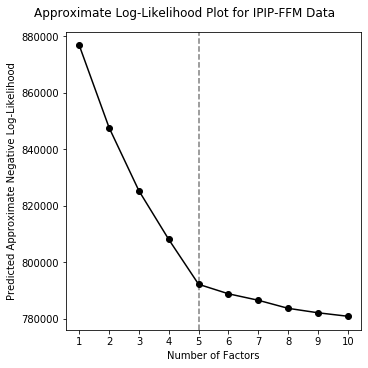

In [7]:
fig, ax = plt.subplots(constrained_layout = True)
fig.set_size_inches(5, 5, forward = True)
fig.set_size_inches(5, 5, forward = True)
ax.axvline(x = 5, color = "gray", linestyle = "--")
ax.plot(np.arange(1, 11).tolist(), [ll for ll in ll_ls], "k-o")
ax.set_xticks(np.arange(1, 11).tolist())
ax.set_ylabel("Predicted Approximate Negative Log-Likelihood")
ax.set_xlabel("Number of Factors")
fig.suptitle("Approximate Log-Likelihood Plot for IPIP-FFM Data")
fig.show()

pdf = matplotlib.backends.backend_pdf.PdfPages("ipip-ffm_scree_plot.pdf")
pdf.savefig(fig, dpi = 300)
pdf.close()

/Users/sharahe/Desktop/School/GatesLab/deep_exploratory_ifa/mirt_vae.py:435: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


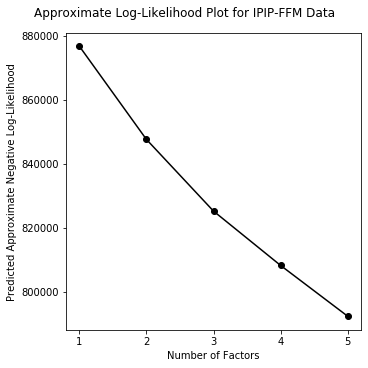

In [30]:
scree_plot(dimensions = 5, ll_ls = log_likelihoods)

In [ ]:
loadings_heatmap(rot_loadings)

In [35]:
ipip_vae.generate_intercepts()

AttributeError: 'MIRTVAEClass' object has no attribute 'generate_intercepts'